In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset,DataLoader
from data import load_traindata
device = 'mps' if torch.backends.mps.is_available() else ('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import random_split
from torch.optim.lr_scheduler import LambdaLR

cuda


In [2]:
torch.manual_seed(42)

In [ ]:
num_subclasses = 9000
epochs = 100
seq_size = 1250

In [5]:
class Discriminator(nn.Module):
    def __init__(self, seq_size, num_filters=64):
        super(Discriminator, self).__init__()

        self.conv1 = nn.Conv1d(in_channels=1, out_channels=num_filters, kernel_size=4, stride=2, padding=1)
        self.leakyRelu = nn.LeakyReLU(0.2, inplace=True)

        self.conv2 = nn.Conv1d(in_channels=num_filters, out_channels=num_filters*2, kernel_size=4, stride=2, padding=1)
        self.bn1 = nn.BatchNorm1d(num_filters*2)

        self.conv3 = nn.Conv1d(in_channels=num_filters*2, out_channels=num_filters*4, kernel_size=4, stride=2, padding=1)
        self.bn2 = nn.BatchNorm1d(num_filters*4)

        self.conv4 = nn.Conv1d(in_channels=num_filters*4, out_channels=num_filters*8, kernel_size=4, stride=2, padding=1)
        self.bn3 = nn.BatchNorm1d(num_filters*8)

        self.conv5 = nn.Conv1d(in_channels=num_filters*8, out_channels=num_filters*8, kernel_size=4, stride=2, padding=1)
        self.bn4 = nn.BatchNorm1d(num_filters*8)

        self.conv6 = nn.Conv1d(in_channels=num_filters*8, out_channels=1, kernel_size=4, stride=2, padding=1)
        self.op = nn.Linear(19,1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.leakyRelu(x)

        x = self.conv2(x)
        x = self.bn1(x)
        x = self.leakyRelu(x)

        x = self.conv3(x)
        x = self.bn2(x)
        x = self.leakyRelu(x)

        x = self.conv4(x)
        x = self.bn3(x)
        x = self.leakyRelu(x)

        x = self.conv5(x)
        x = self.bn4(x)
        x = self.leakyRelu(x)

        x = self.conv6(x)
        x = self.leakyRelu(x)
        x = self.op(x)
        x = self.sigmoid(x)
        return x.squeeze(2)
# seq_size = 1250
# batch_size = 32
# model = Discriminator(seq_size)

# sample_input = torch.randn(batch_size, 1, seq_size)
# output = model(sample_input)

# print(output.shape)


In [7]:
class Generator(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, num_filters = 32):
        super(Generator, self).__init__()
        self.enc1 = nn.Sequential(
            nn.Conv1d(in_channels, num_filters, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2)
        )
        self.enc2 = nn.Sequential(
            nn.Conv1d(num_filters, num_filters*2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(num_filters*2),
            nn.LeakyReLU(0.2)
        )
        self.enc3 = nn.Sequential(
            nn.Conv1d(num_filters*2, num_filters*4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(num_filters*4),
            nn.LeakyReLU(0.2)
        )
        self.enc4 = nn.Sequential(
            nn.Conv1d(num_filters*4, num_filters*8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(num_filters*8),
            nn.LeakyReLU(0.2)
        )
        self.enc5 = nn.Sequential(
            nn.Conv1d(num_filters*8, num_filters*8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(num_filters*8),
            nn.LeakyReLU(0.2)
        )
        self.enc6 = nn.Sequential(
            nn.Conv1d(num_filters*8, num_filters*8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(num_filters*8),
            nn.LeakyReLU(0.2)
        )
        self.enc7 = nn.Sequential(
            nn.Conv1d(num_filters*8, num_filters*16, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(num_filters*16),
            nn.LeakyReLU(0.2)
        )

        # Decoder 
        self.dec1 = nn.Sequential(
            nn.ConvTranspose1d(num_filters*16, num_filters*8, kernel_size=4, stride=2, padding=1, output_padding=1),
            nn.BatchNorm1d(num_filters*8),
            nn.Dropout1d(0.2),
            nn.ReLU(),

        )
        self.dec2 = nn.Sequential(
            nn.ConvTranspose1d(num_filters*8, num_filters*8, kernel_size=4, stride=2, padding=1, output_padding=1),  # Skip connection
            nn.BatchNorm1d(num_filters*8),
            nn.Dropout1d(0.2),
            nn.ReLU()
        )
        self.dec3 = nn.Sequential(
            nn.ConvTranspose1d(num_filters*8, num_filters*8, kernel_size=4, stride=2, padding=1),  # Skip connection
            nn.BatchNorm1d(num_filters*8),
            nn.Dropout1d(0.2),
            nn.ReLU()
        )
        self.dec4 = nn.Sequential(
            nn.ConvTranspose1d(num_filters*8, num_filters*4, kernel_size=4, stride=2, padding=1),  # Skip connection
            nn.BatchNorm1d(num_filters*4),
            nn.ReLU()
        )
        self.dec5 = nn.Sequential(
            nn.ConvTranspose1d(num_filters*4, num_filters*2, kernel_size=4, stride=2, padding=1),  # Skip connection
            nn.BatchNorm1d(num_filters*2),
            nn.ReLU()
        )
        self.dec6 = nn.Sequential(
            nn.ConvTranspose1d(num_filters*2, num_filters, kernel_size=4, stride=2, padding=1, output_padding=1),  # Skip connection
            nn.BatchNorm1d(num_filters),
            nn.ReLU()
        )
        self.dec7 = nn.ConvTranspose1d(num_filters, out_channels, kernel_size=4, stride=2, padding=1)  # Skip connection, no BN
        self.final_activation = nn.LeakyReLU(0.2)

    def forward(self, x):
        # Encoder
        x = x.unsqueeze(1)
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)
        e4 = self.enc4(e3)
        e5 = self.enc5(e4)
        e6 = self.enc6(e5)
        e7 = self.enc7(e6)
        #print(e7.shape, "END OF ENCODER")

        # Decoder with skip connections
        d1 = e6 + self.dec1(e7)
        d2 = e5 + self.dec2(d1)  
        d3 = e4 + self.dec3(d2)
        d4 = e3 + self.dec4(d3)
        d5 = e2 + self.dec5(d4)
        d6 = e1 + self.dec6(d5)
        d7 = self.dec7(d6)
        return self.final_activation(d7)

In [8]:
X, _ = load_traindata(num_subclasses)
X = torch.tensor(X, dtype=torch.float32)
X = X.reshape(num_subclasses, int(5000 / seq_size), seq_size, 12)
X = X.reshape(num_subclasses *  int(5000 / seq_size), seq_size, 12)
X_input = X[:, :, 0]  # First channel
Y_target = X[:, :, 1]  # Second channel

(9514, 28)


In [16]:
dataset = TensorDataset(X_input, Y_target)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Initialize models
generator = Generator().to(device)
discriminator = Discriminator(seq_size).to(device)

# Loss function and optimizers
criterion = nn.BCELoss()
optimizer_g = torch.optim.Adam(generator.parameters(), lr=0.0005)
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=0.0001)
print(sum(p.numel() for p in generator.parameters())/1e6, 'M parameters for Generator')
print(sum(p.numel() for p in discriminator.parameters())/1e6, 'M parameters for Discriminator')

2.448897 M parameters for Generator
1.743317 M parameters for Discriminator


In [17]:
def plotWave(X, Y):
    plt.figure(figsize=(20, 6))
    plt.plot(X.squeeze(0).detach().cpu().numpy(), color='blue', label='X')
    plt.plot(Y.squeeze(0).detach().cpu().numpy(), color='red', label='Y')
    plt.legend()
    plt.show()

In [ ]:
g_losses, d_losses = [], []

Epoch 1/100, D Loss: 1.8873038982319956e-12, G Loss: 27.026081085205078
Epoch 2/100, D Loss: 1.7528801760785528e-12, G Loss: 27.27397918701172
Epoch 3/100, D Loss: 1.5867079785486515e-12, G Loss: 27.184934616088867
Epoch 4/100, D Loss: 1.433078482271366e-12, G Loss: 27.325637817382812
Epoch 5/100, D Loss: 2.705835772456866e-12, G Loss: 28.452537536621094
Epoch 6/100, D Loss: 8.174281564132801e-12, G Loss: 30.07786750793457
Epoch 7/100, D Loss: 9.625409844171706e-12, G Loss: 30.988689422607422
Epoch 8/100, D Loss: 1.5596086921920715e-11, G Loss: 30.483840942382812
Epoch 9/100, D Loss: 3.474984189288932e-11, G Loss: 31.86882972717285
9


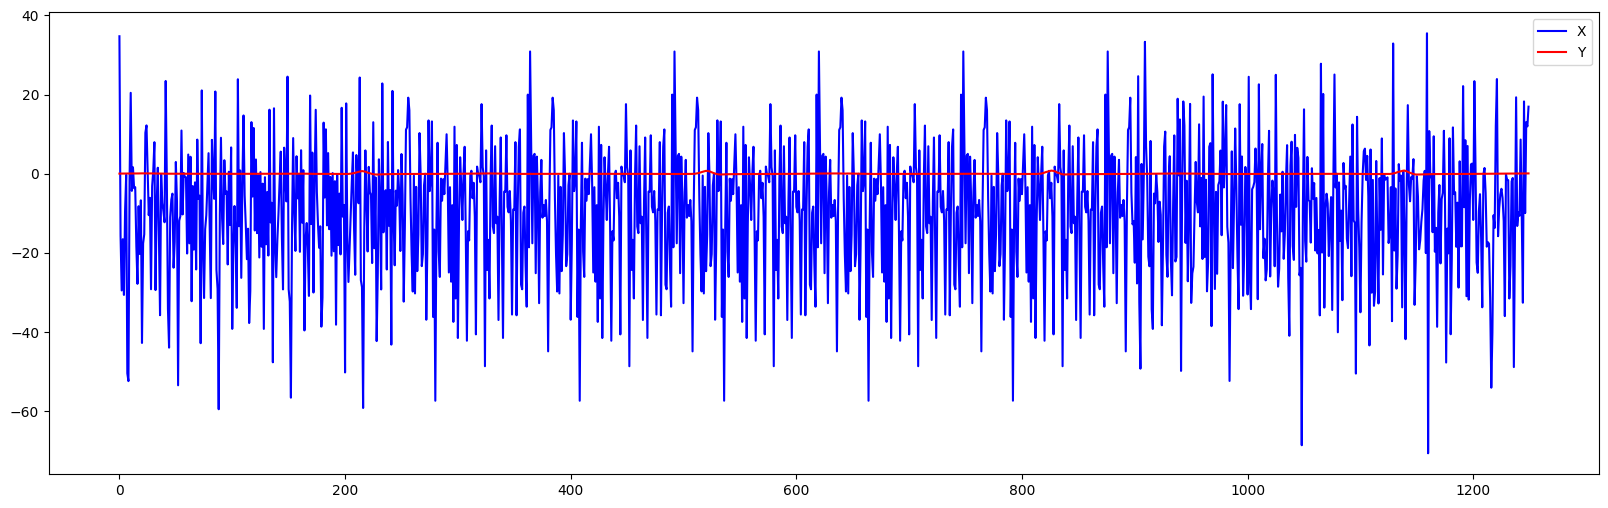

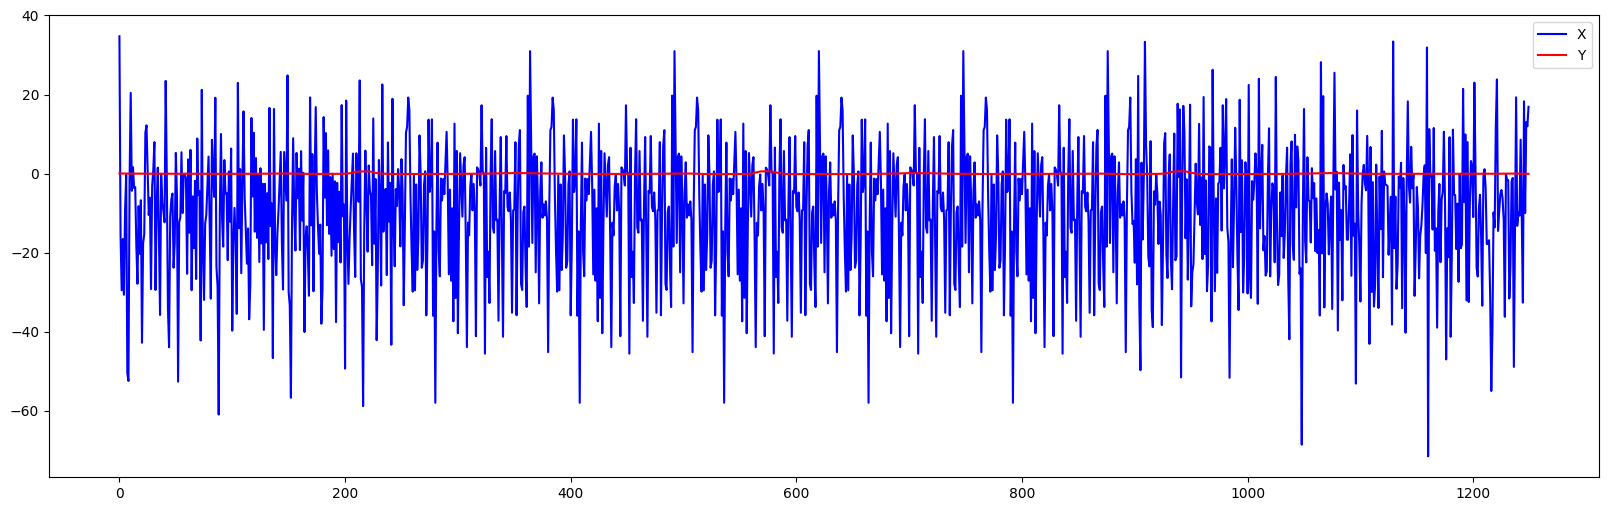

Epoch 10/100, D Loss: 5.083751995760277e-12, G Loss: 30.659038543701172
Epoch 11/100, D Loss: 6.957575487964718e-11, G Loss: 33.45753860473633
Epoch 12/100, D Loss: 9.749368846956319e-12, G Loss: 33.38793182373047
Epoch 13/100, D Loss: 1.028915494472038e-11, G Loss: 31.35858726501465
Epoch 14/100, D Loss: 9.549890739313227e-11, G Loss: 30.45234489440918
Epoch 15/100, D Loss: 2.497717310756542e-10, G Loss: 30.65616226196289
Epoch 16/100, D Loss: 5.586569748472492e-11, G Loss: 32.40822219848633
Epoch 17/100, D Loss: 7.1214076302617e-11, G Loss: 33.87482452392578
Epoch 18/100, D Loss: 6.306215272200433e-11, G Loss: 33.38593292236328
Epoch 19/100, D Loss: 3.205471998946052e-11, G Loss: 30.681718826293945
19


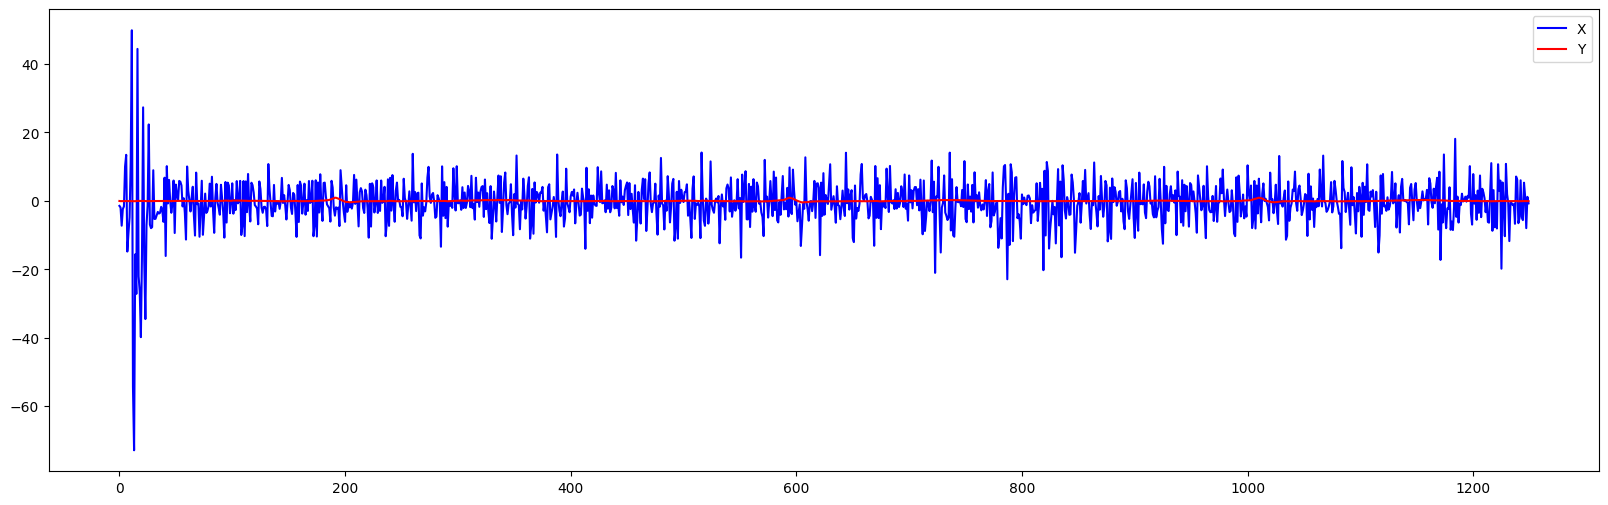

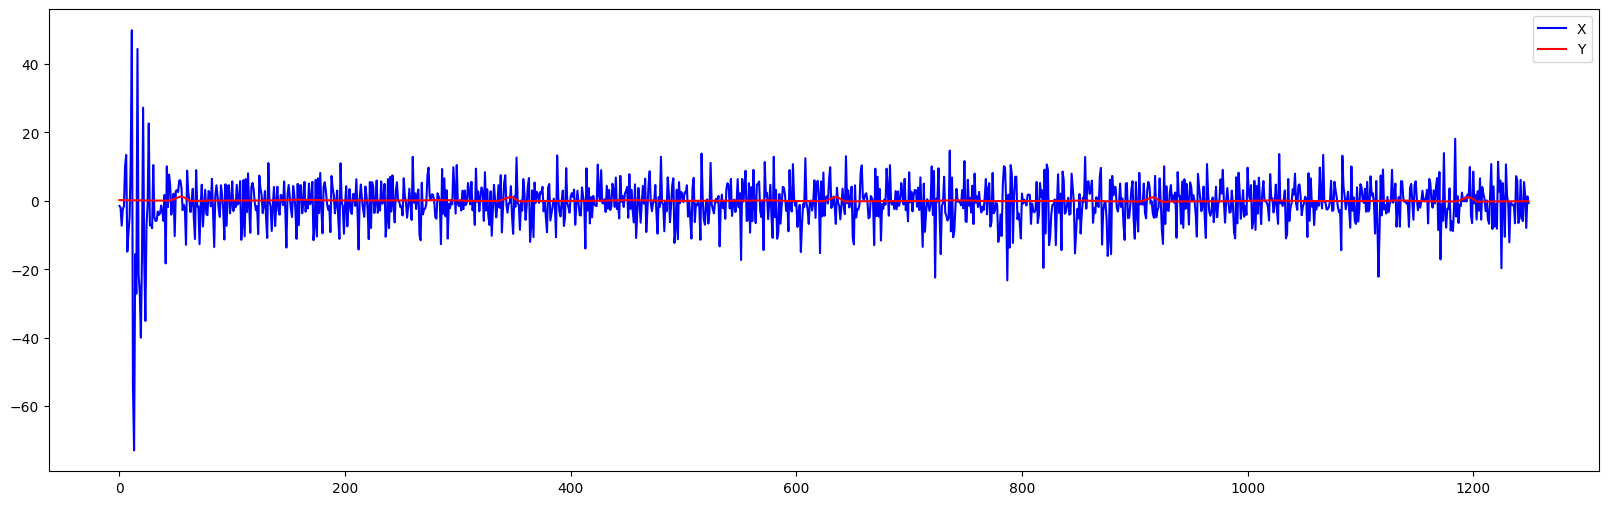

Epoch 20/100, D Loss: 2.825433637054786e-11, G Loss: 32.77305603027344
Epoch 21/100, D Loss: 1.865895632446879e-11, G Loss: 31.342670440673828
Epoch 22/100, D Loss: 1.3218526100089445e-11, G Loss: 33.58287048339844
Epoch 23/100, D Loss: 9.462168895635337e-12, G Loss: 34.574462890625
Epoch 24/100, D Loss: 9.04306837745672e-12, G Loss: 34.65357971191406
Epoch 25/100, D Loss: 9.424472487140623e-12, G Loss: 33.77949142456055
Epoch 26/100, D Loss: 8.521875913269916e-12, G Loss: 37.4666748046875
Epoch 27/100, D Loss: 7.839160744149698e-12, G Loss: 32.19312286376953
Epoch 28/100, D Loss: 7.112617786408926e-12, G Loss: 34.08606719970703
Epoch 29/100, D Loss: 6.5158416856503365e-12, G Loss: 31.305561065673828
29


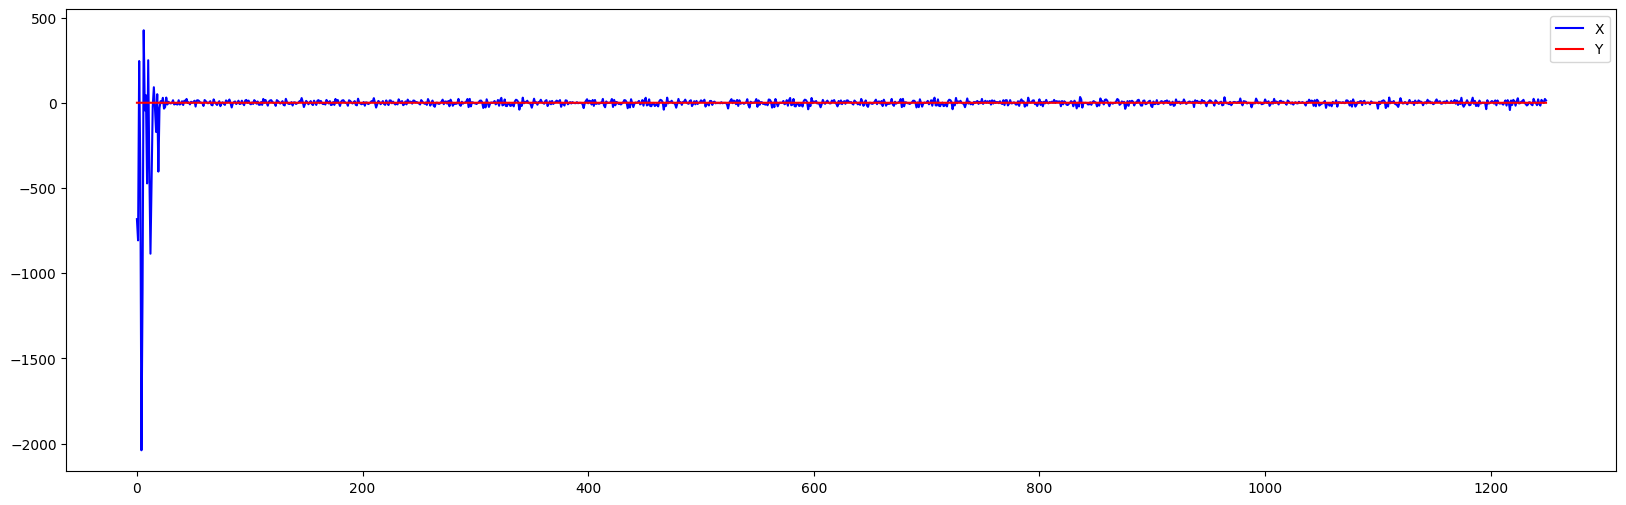

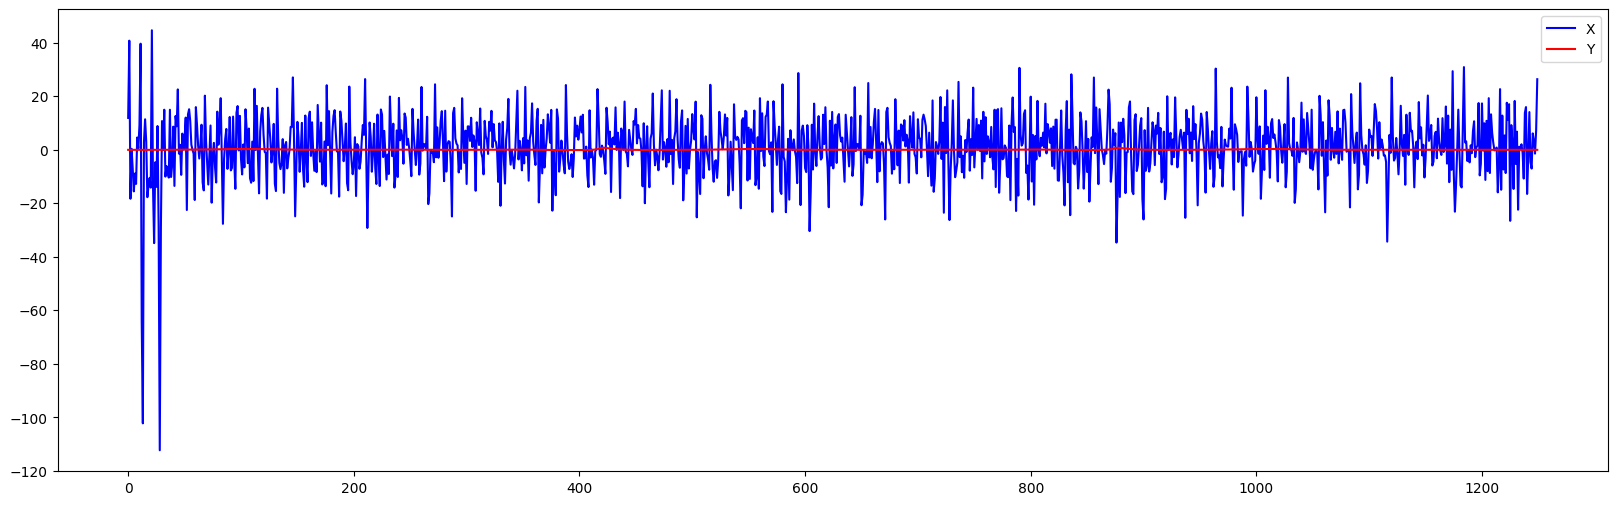

Epoch 30/100, D Loss: 5.346011827667141e-12, G Loss: 35.106483459472656
Epoch 31/100, D Loss: 5.0361572551116396e-12, G Loss: 35.14363098144531
Epoch 32/100, D Loss: 4.427892948133394e-12, G Loss: 36.704002380371094
Epoch 33/100, D Loss: 4.128985348073044e-12, G Loss: 33.66527557373047
Epoch 34/100, D Loss: 3.352508591916714e-12, G Loss: 32.921844482421875
Epoch 35/100, D Loss: 3.7252193517411936e-12, G Loss: 34.55387878417969
Epoch 36/100, D Loss: 3.6362547087970265e-12, G Loss: 33.774681091308594
Epoch 37/100, D Loss: 3.5120500258001286e-12, G Loss: 38.209266662597656
Epoch 38/100, D Loss: 3.4302090248100603e-12, G Loss: 36.27376937866211
Epoch 39/100, D Loss: 3.699475621676829e-12, G Loss: 35.44468688964844
39


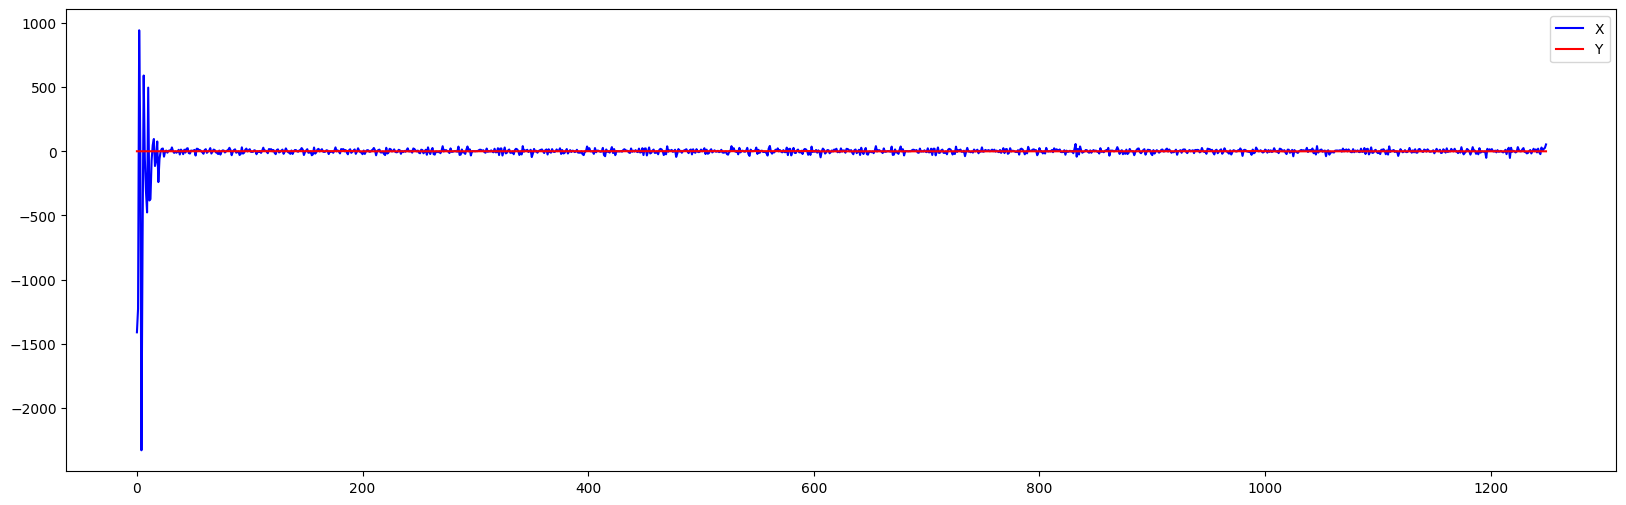

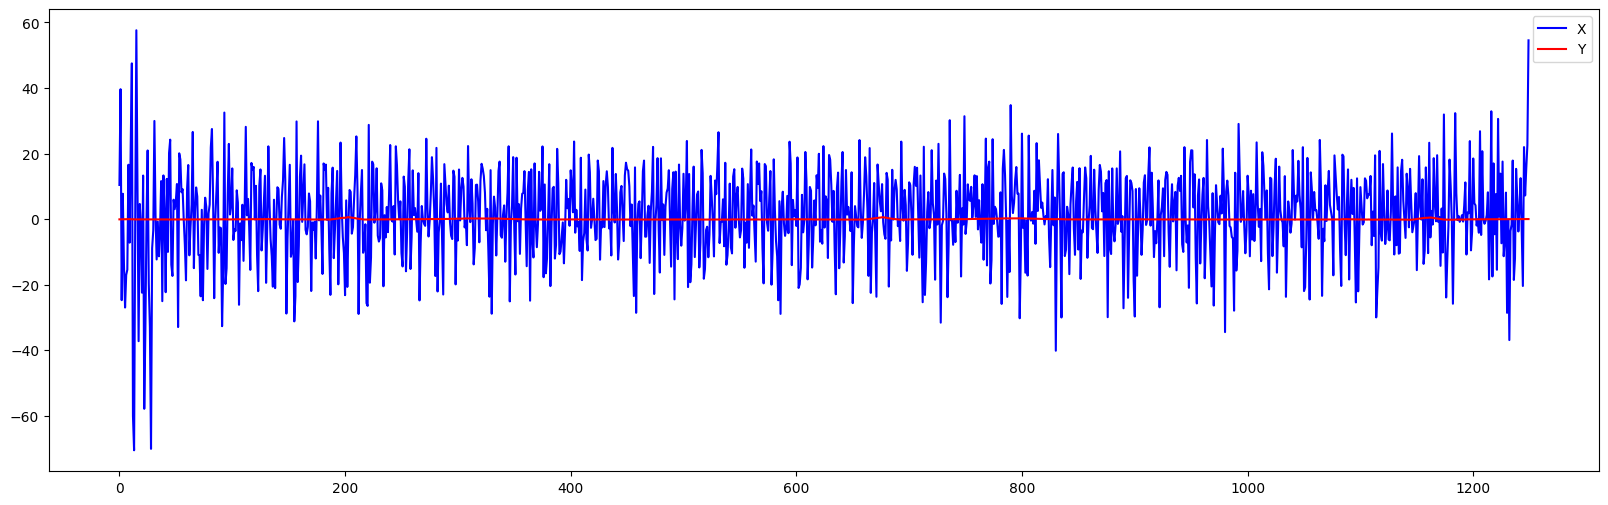

Epoch 40/100, D Loss: 4.703635484576418e-12, G Loss: 28.37644386291504
Epoch 41/100, D Loss: 4.556150595691477e-12, G Loss: 34.472312927246094
Epoch 42/100, D Loss: 4.2263553767796225e-12, G Loss: 32.74467086791992
Epoch 43/100, D Loss: 3.985469506501138e-12, G Loss: 32.808895111083984
Epoch 44/100, D Loss: 3.652723522956647e-12, G Loss: 32.89958572387695
Epoch 45/100, D Loss: 4.579441426760811e-12, G Loss: 36.97739791870117
Epoch 46/100, D Loss: 3.77631996853478e-12, G Loss: 35.617034912109375
Epoch 47/100, D Loss: 3.1367530101134022e-12, G Loss: 33.0492057800293
Epoch 48/100, D Loss: 4.077088926884853e-12, G Loss: 33.92965316772461
Epoch 49/100, D Loss: 7.403211724210657e-12, G Loss: 37.66866683959961
49


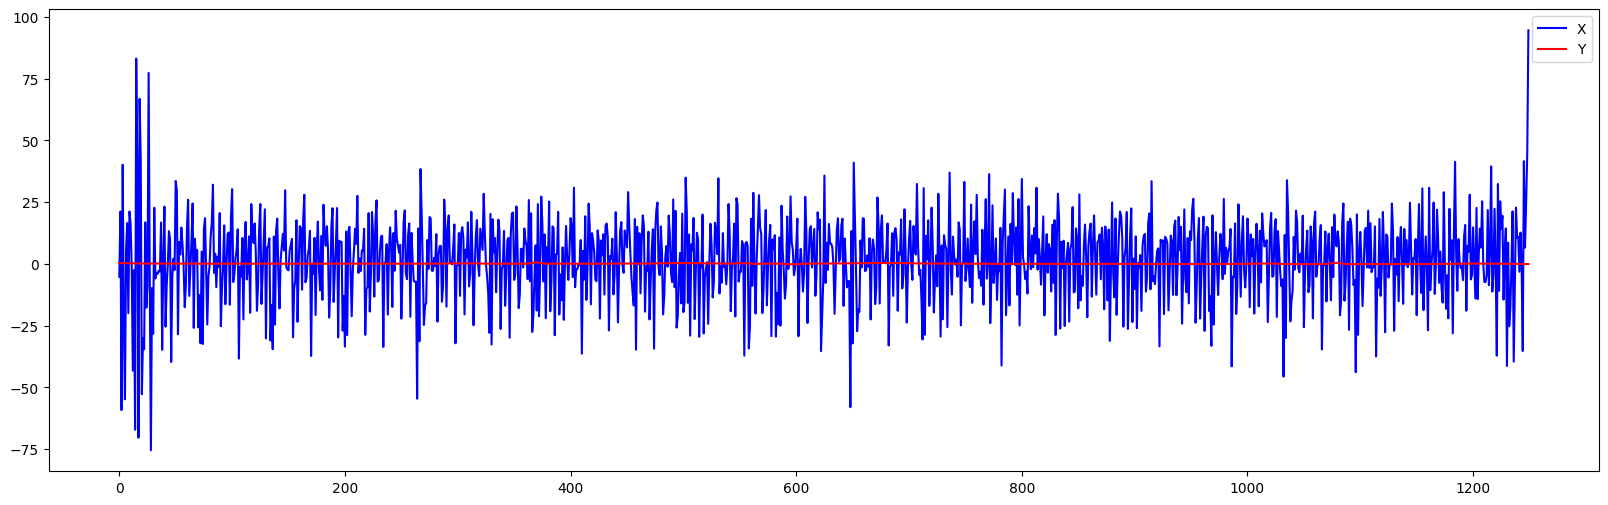

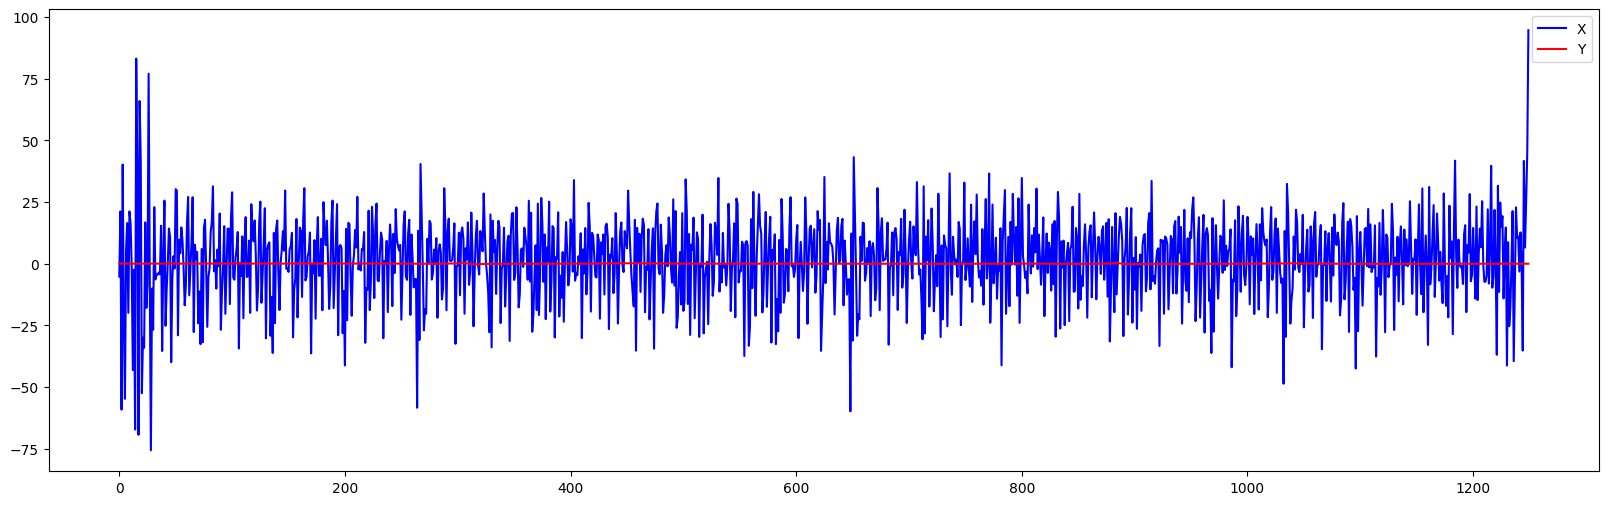

Epoch 50/100, D Loss: 5.105834158247724e-12, G Loss: 35.61702346801758
Epoch 51/100, D Loss: 3.664985849527458e-12, G Loss: 33.15291213989258
Epoch 52/100, D Loss: 4.606925951833318e-12, G Loss: 36.599491119384766
Epoch 53/100, D Loss: 3.2353143601671075e-12, G Loss: 34.27981948852539
Epoch 54/100, D Loss: 2.781122554473825e-12, G Loss: 33.39822006225586
Epoch 55/100, D Loss: 3.650698233298444e-12, G Loss: 37.50382995605469
Epoch 56/100, D Loss: 2.7095665121323886e-12, G Loss: 34.417274475097656
Epoch 57/100, D Loss: 1.2546175209848798e-10, G Loss: 42.52937316894531
Epoch 58/100, D Loss: 2.1830336149886165e-11, G Loss: 45.677974700927734
Epoch 59/100, D Loss: 7.158169890164601e-11, G Loss: 45.43590545654297
59


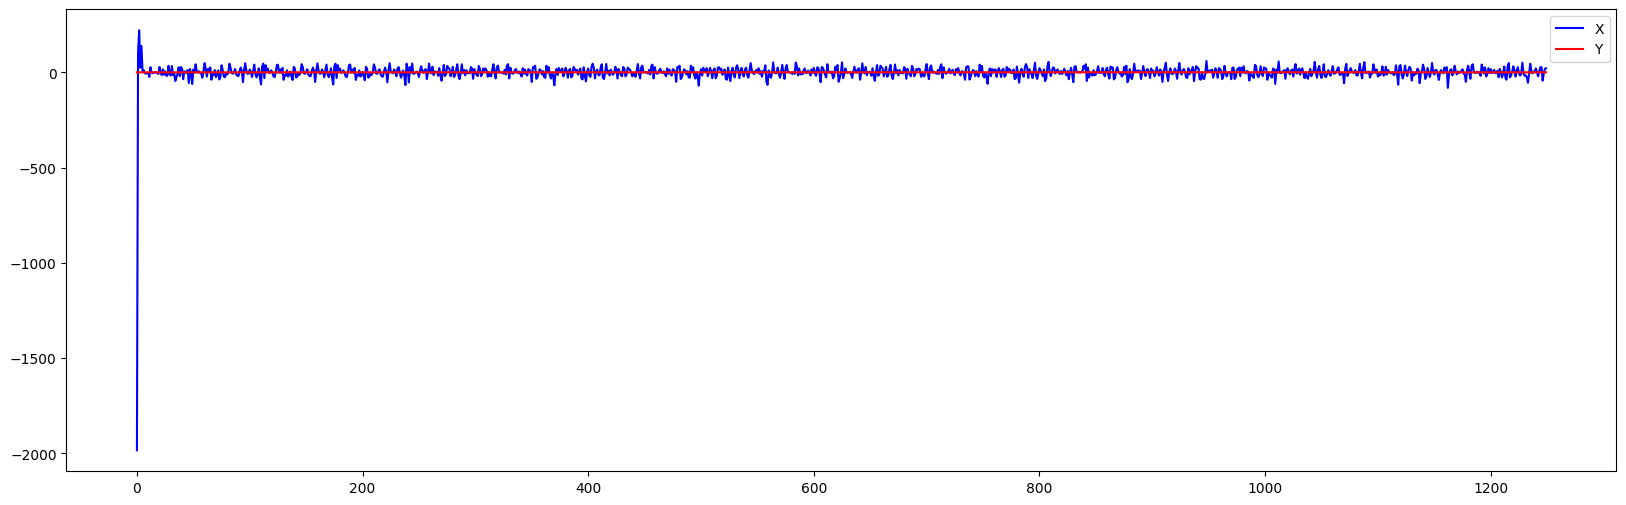

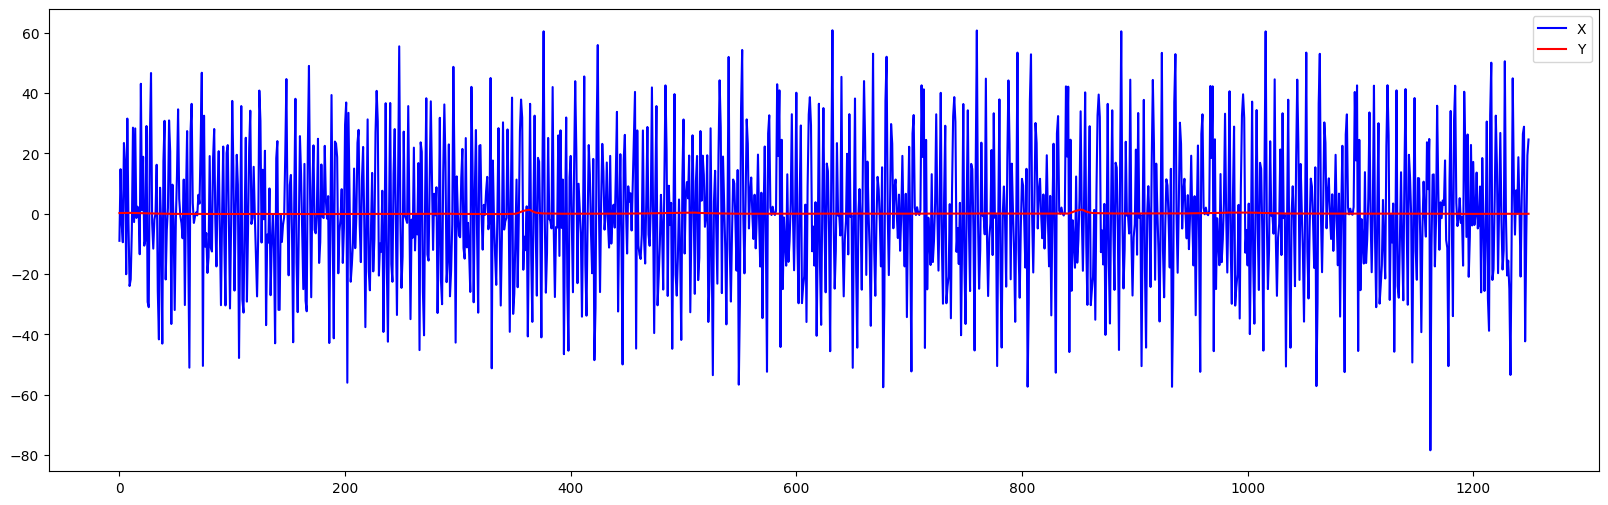

Epoch 60/100, D Loss: 5.337119635129284e-11, G Loss: 51.697669982910156
Epoch 61/100, D Loss: 6.092267662571871e-11, G Loss: 58.196739196777344
Epoch 62/100, D Loss: 1.2077910893637522e-10, G Loss: 58.43205261230469
Epoch 63/100, D Loss: 2.9066180018411103e-11, G Loss: 58.47547912597656
Epoch 64/100, D Loss: 1.3202529347555725e-11, G Loss: 59.01583480834961
Epoch 65/100, D Loss: 7.741488656717865e-13, G Loss: 60.65657043457031
Epoch 66/100, D Loss: 7.825393805171998e-11, G Loss: 62.207462310791016
Epoch 67/100, D Loss: 4.755512823806374e-12, G Loss: 61.72980499267578
Epoch 68/100, D Loss: 8.698982506549768e-12, G Loss: 62.22090148925781
Epoch 69/100, D Loss: 1.339065143490803e-11, G Loss: 61.999427795410156
69


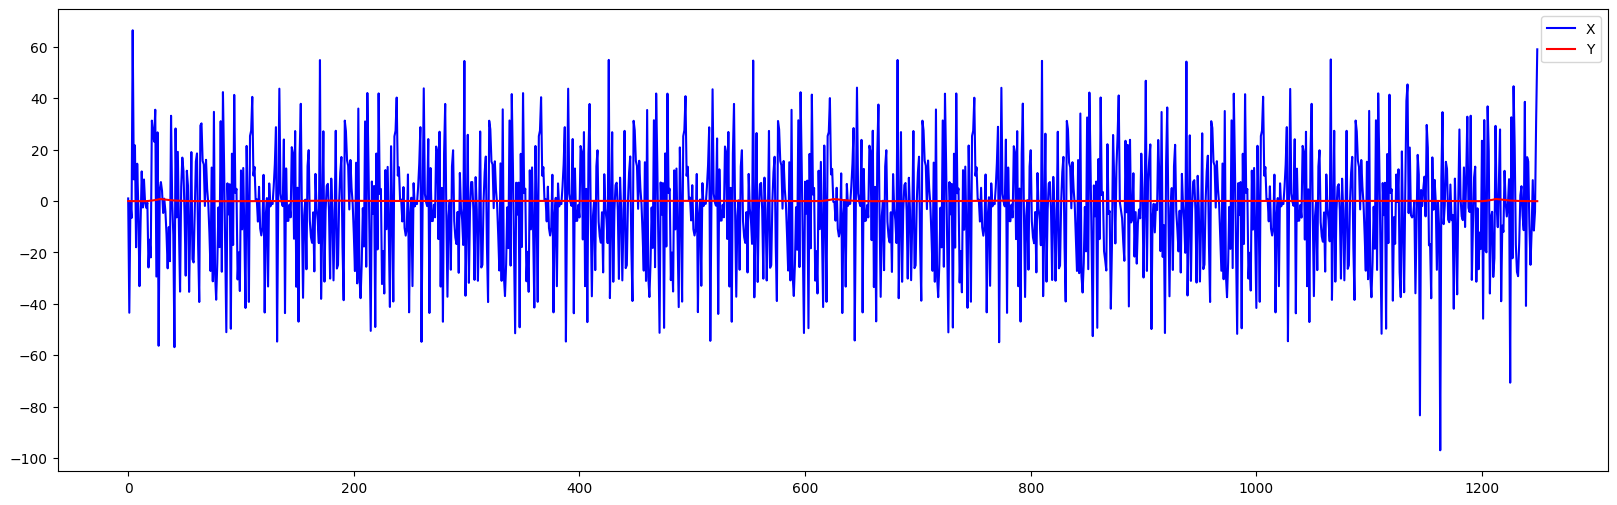

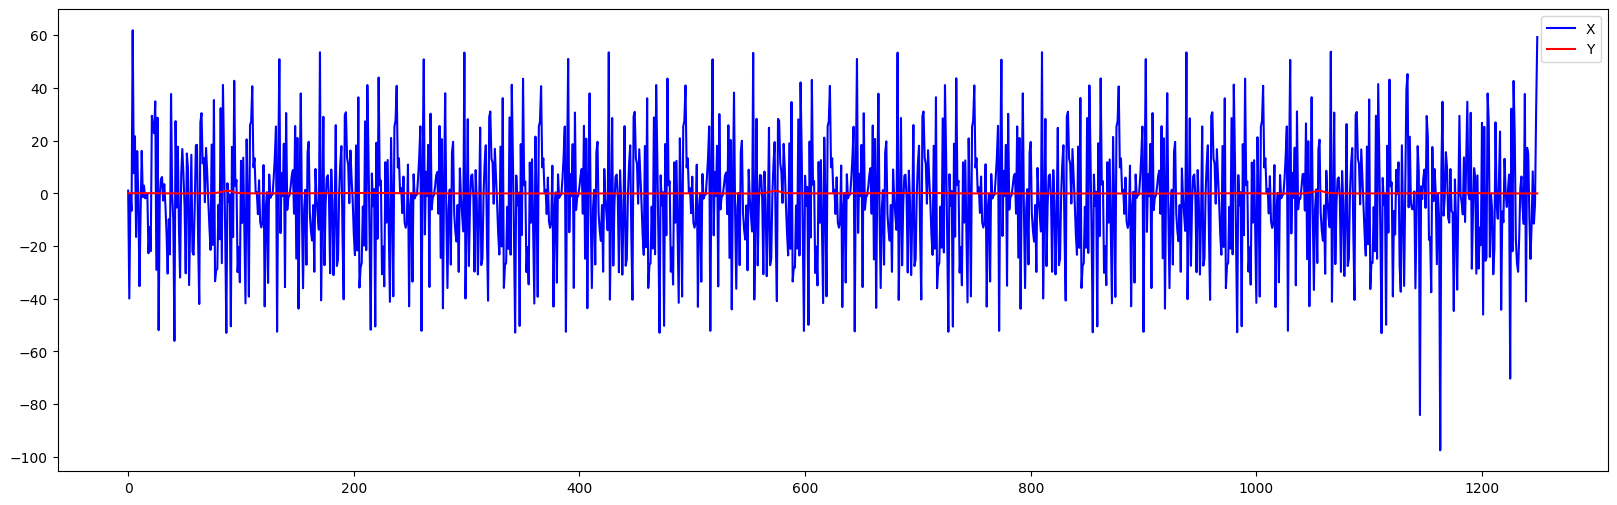

Epoch 70/100, D Loss: 3.682856970776971e-12, G Loss: 61.42652130126953
Epoch 71/100, D Loss: 2.2596450752199182e-11, G Loss: 61.27428436279297
Epoch 72/100, D Loss: 2.2510237438346578e-23, G Loss: 63.88804244995117
Epoch 73/100, D Loss: 2.3220811787333456e-23, G Loss: 63.82965087890625
Epoch 74/100, D Loss: 8.518471886540214e-24, G Loss: 63.451900482177734
Epoch 75/100, D Loss: 9.277748141232722e-24, G Loss: 63.27199935913086
Epoch 76/100, D Loss: 1.1554411757753235e-23, G Loss: 63.662635803222656
Epoch 77/100, D Loss: 1.9024497756446493e-23, G Loss: 63.90446090698242
Epoch 78/100, D Loss: 1.7756799859478137e-23, G Loss: 63.365234375
Epoch 79/100, D Loss: 1.5223578166196215e-23, G Loss: 63.507843017578125
79


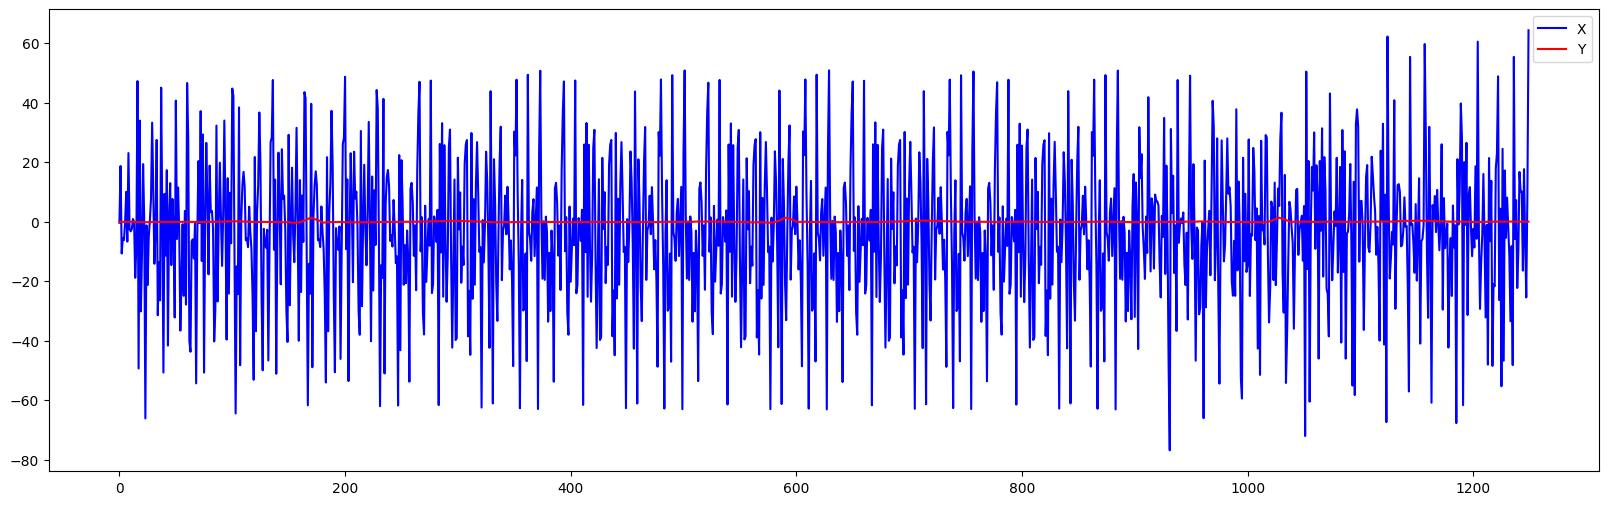

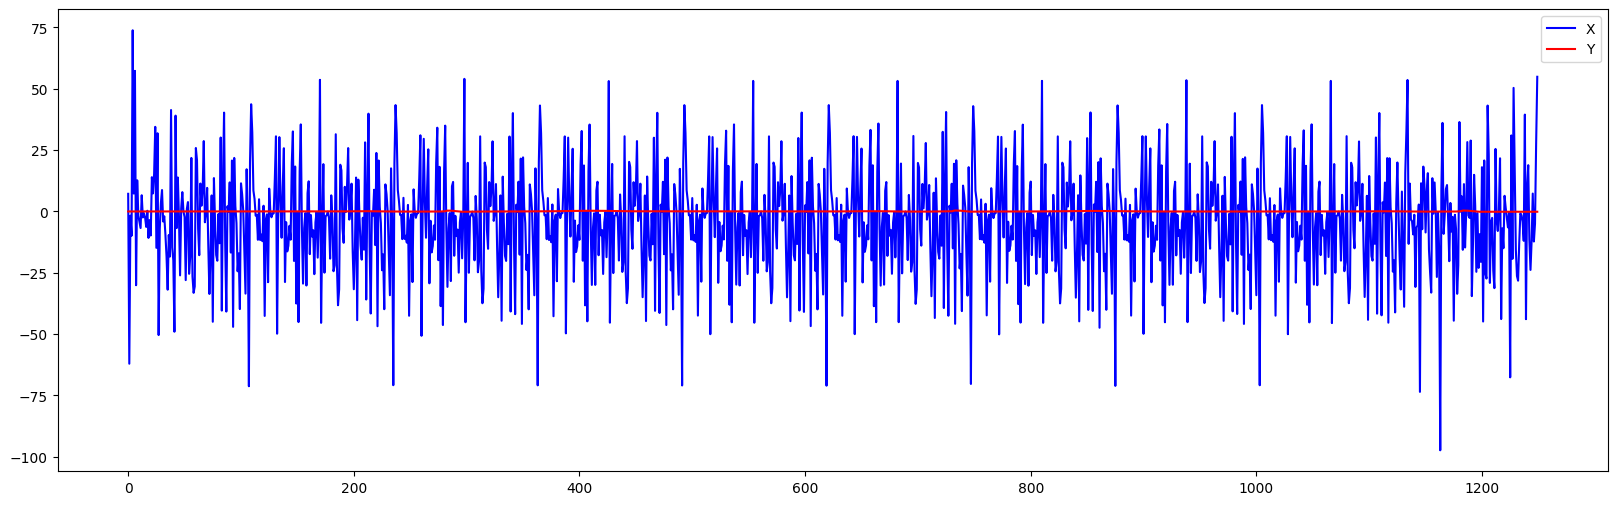

Epoch 80/100, D Loss: 1.5006882611482208e-24, G Loss: 63.193626403808594
Epoch 81/100, D Loss: 2.5630167724568933e-24, G Loss: 63.1098747253418
Epoch 82/100, D Loss: 5.326493592780485e-23, G Loss: 64.07058715820312
Epoch 83/100, D Loss: 1.4249967614694253e-23, G Loss: 63.769142150878906
Epoch 84/100, D Loss: 1.858096860109503e-23, G Loss: 63.69544219970703
Epoch 85/100, D Loss: 4.07705088379203e-23, G Loss: 63.44226837158203
Epoch 86/100, D Loss: 1.184380774741628e-24, G Loss: 63.2852897644043
Epoch 87/100, D Loss: 6.1526488439289065e-24, G Loss: 63.72404479980469
Epoch 88/100, D Loss: 9.390037757925502e-24, G Loss: 63.832374572753906
Epoch 89/100, D Loss: 8.915325719851559e-24, G Loss: 63.180702209472656
89


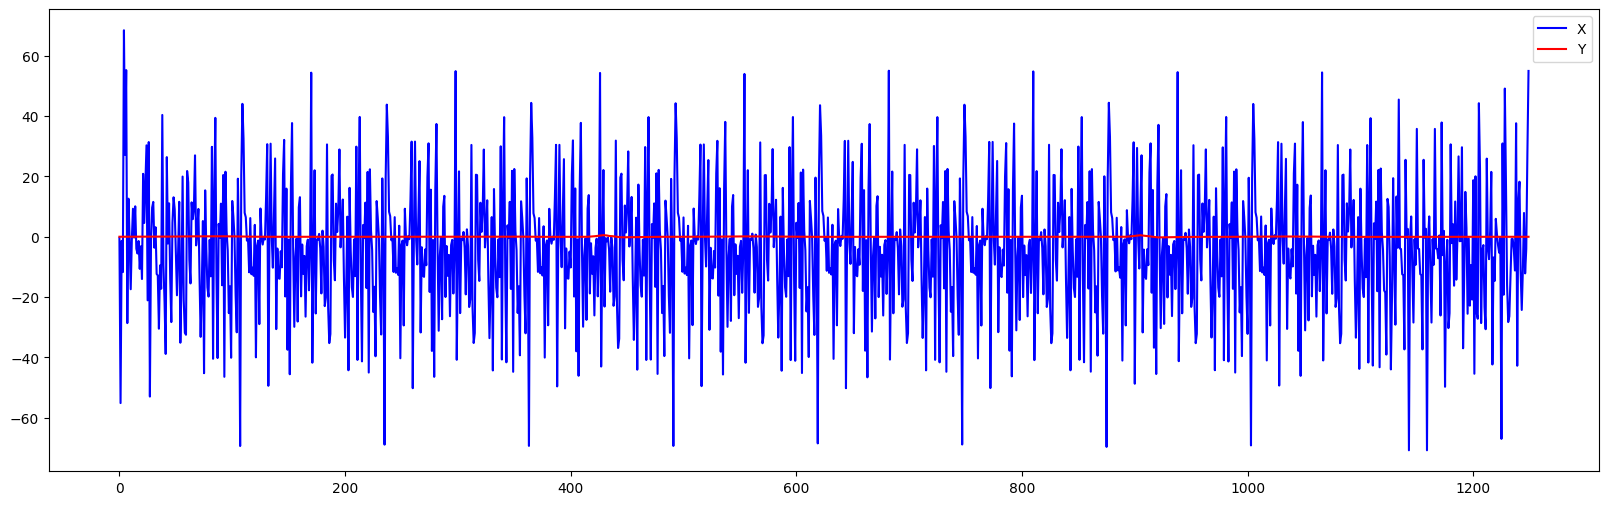

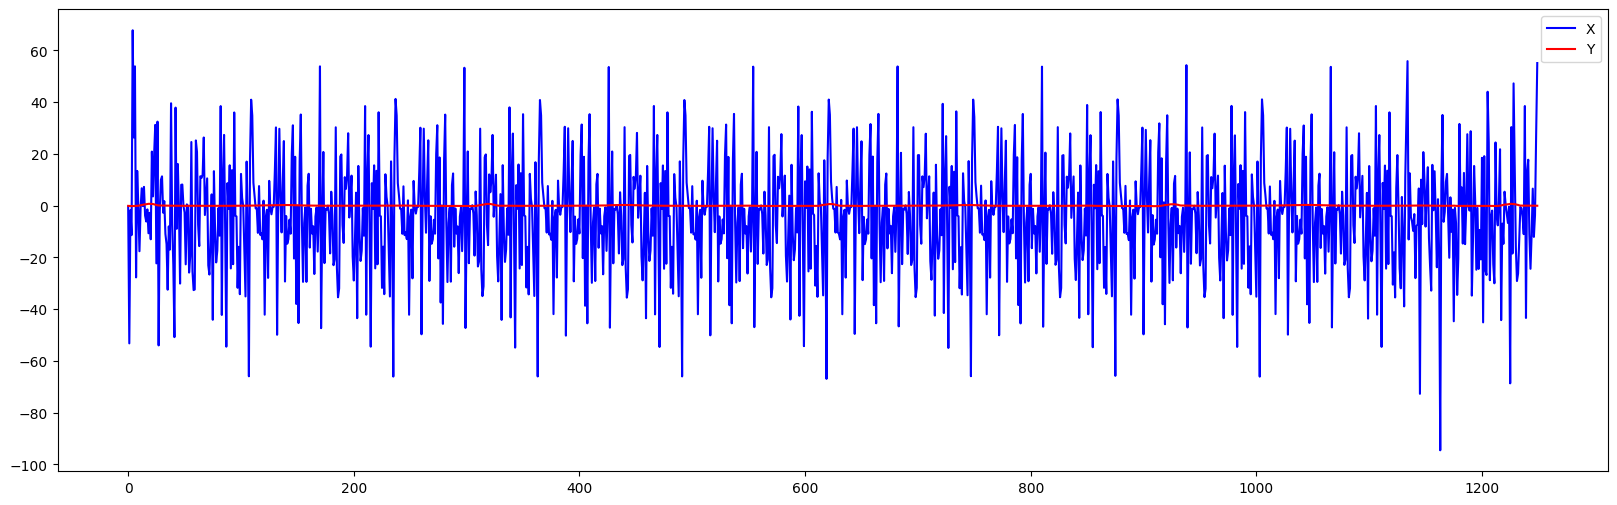

Epoch 90/100, D Loss: 2.1139198368363817e-24, G Loss: 62.93290328979492
Epoch 91/100, D Loss: 2.06215119491866e-23, G Loss: 63.94105911254883
Epoch 92/100, D Loss: 2.1375325342110454e-23, G Loss: 63.41756820678711
Epoch 93/100, D Loss: 2.1600843144328415e-27, G Loss: 62.41794204711914
Epoch 94/100, D Loss: 1.51473354938711e-28, G Loss: 65.4331283569336
Epoch 95/100, D Loss: 8.246951188781453e-29, G Loss: 65.72566223144531
Epoch 96/100, D Loss: 8.121082639119133e-29, G Loss: 65.69906616210938
Epoch 97/100, D Loss: 1.5548540405060987e-28, G Loss: 65.3275146484375
Epoch 98/100, D Loss: 6.910715113681961e-29, G Loss: 65.67544555664062
Epoch 99/100, D Loss: 7.332695994146926e-29, G Loss: 65.65906524658203
99


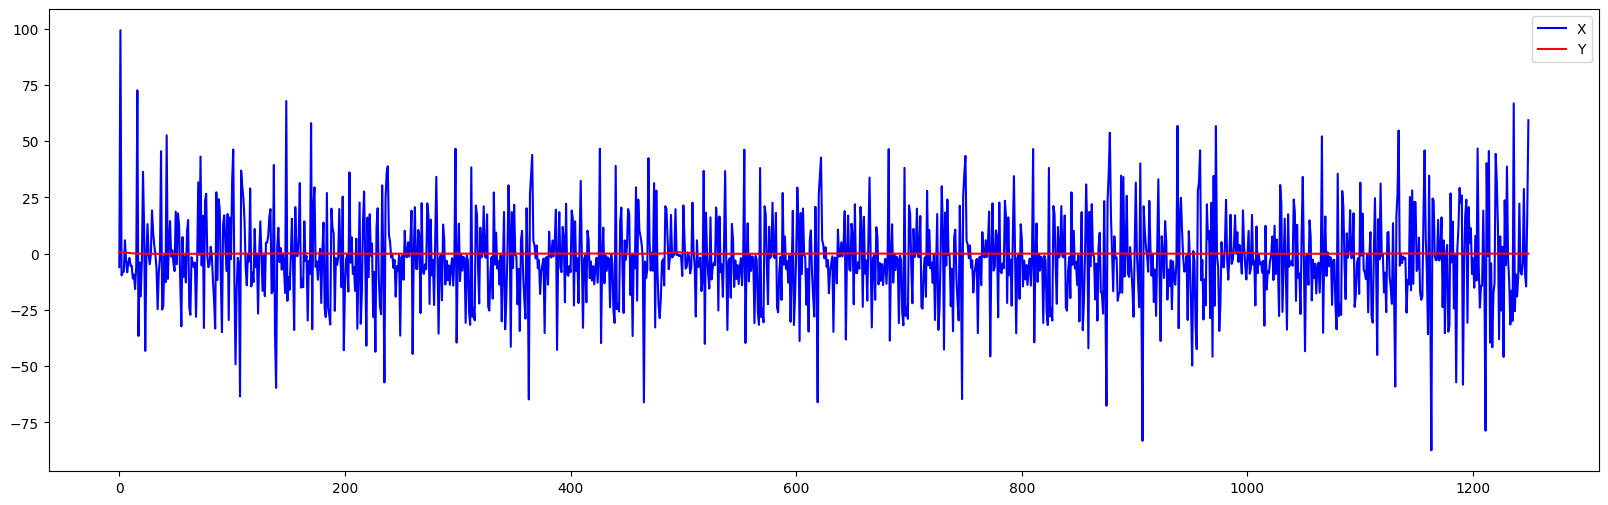

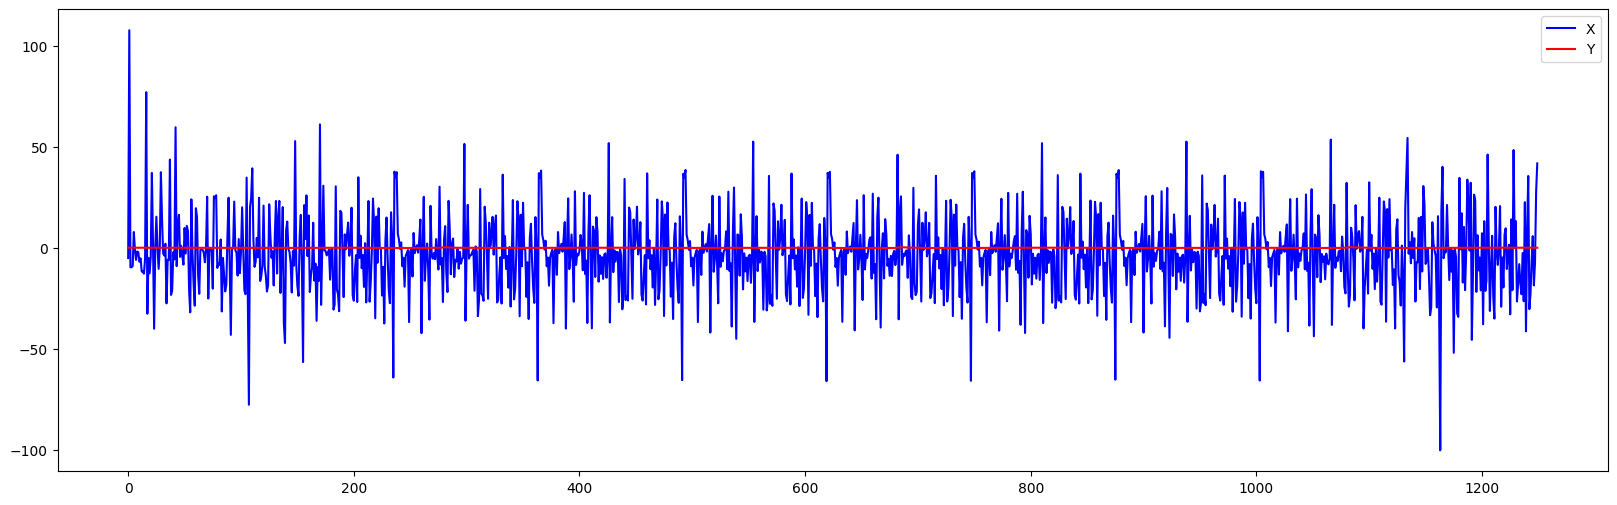

Epoch 100/100, D Loss: 1.012491945902237e-28, G Loss: 65.21501159667969


In [20]:
for epoch in range(epochs):
    for real_1, real_2 in dataloader:
        real_1, real_2 = real_1.to(torch.float32),real_2.to(torch.float32)
        real_1, real_2 = real_1.to(device), real_2.to(device)
        batch_size = real_1.size(0)
        
        # Train Discriminator
        optimizer_d.zero_grad()
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)
        
        fake_2 = generator(real_1)
        fake_output = discriminator(fake_2.detach())
        fake_loss = criterion(fake_output, fake_labels)
        real_2  = real_2.unsqueeze(1)
        real_output = discriminator(real_2)
        real_loss = criterion(real_output, real_labels)
        
        d_loss = (real_loss + fake_loss)
        d_loss.backward()
        optimizer_d.step()
        
        # Train Generator
        optimizer_g.zero_grad()
        fake_output = discriminator(fake_2)
        g_loss = criterion(fake_output, real_labels)
        g_loss.backward()
        optimizer_g.step()
        
    g_losses.append(g_loss.item())
    d_losses.append(d_loss.item())
    if (epoch+1)%10==0:
        print(epoch)
        for real_1, real_2 in dataloader:
            real_1, real_2 = real_1.to(torch.float32),real_2.to(torch.float32)
            real_1, real_2 = real_1.to(device), real_2.to(device)
            fake_2 = generator(real_1)
            plotWave(fake_2[0],real_2[0])
            plotWave(fake_2[12],real_2[12])
            break
    print(f"Epoch {epoch+1}/{epochs}, D Loss: {d_loss.item()}, G Loss: {g_loss.item()}")
